## Курсовой проект "Предсказание цен на недвижимость"

### Задача проекта: предсказать цены на квартиры в датасете test.csv. Даны два датасета: train.csv (содержит признаки и цены на квартиры) и test.csv (только признаки).

#### Содержание проекта
* [Загрузка данных и оптимизация памяти](#load)
* [1. EDA](#eda)
* [2. Обработка выбросов](#outlier)
* [3. Обработка пропусков](#nan)
* [4. Построение новых признаков](#feature)
* [5. Отбор признаков](#feature_selection)
* [6. Разбиение на train и test](#split)
* [7. Построение модели](#modeling)
* [8. Прогнозирование на тестовом датасете](#prediction)

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})

In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Загрузка данных  и оптимизация памяти <a class='anchor' id='load'>

In [3]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'


In [4]:
train = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
train.head()

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809          27    3.0  115.027311         NaN           10.0      4   
1   3013          22    1.0   39.832524   23.169223            8.0      7   
2   8215           1    3.0   78.342215   47.671972           10.0      2   
3   2352           1    1.0   40.409907         NaN            1.0     10   
4  13866          94    2.0   64.285067   38.562517            9.0     16   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0        10.0       2014   0.075424         B         B        11      3097   
1         8.0       1966   0.118537         B         B        30      6207   
2        17.0       1988   0.025609         B         B        33      5261   
3        22.0       1977   0.007122         B         B         1       264   
4        16.0       1972   0.282798         B         B        33      8667   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
0         0           NaN            0        0       B  305018.871089  
1         1        1183.0            1        0       B  177734.553407  
2         0         240.0            3        1       B  282078.720850  
3         0           NaN            0        1       B  168106.007630  
4         2           NaN            0        6       B  343995.102962

**Описание датасета**

* **Id** - id квартиры
* **DistrictId** - id района, в котором расположена квартира
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - этажность дома
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [5]:
test = pd.read_csv(TEST_DATASET_PATH, sep=',')
test.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  4567          44    1.0  36.847630   19.094182            5.0      5   
1  5925          62    1.0  42.493907   42.568133           10.0      7   
2   960          27    2.0  59.463678         NaN            9.0     19   
3  3848          23    3.0  49.646030   33.893825            6.0      2   
4   746          74    1.0  53.837056         NaN            1.0      8   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0         9.0       1970   0.036122         B         B        24      4378   
1        17.0       2017   0.072158         B         B         2       629   
2        19.0       1977   0.211401         B         B         9      1892   
3         2.0       1965   0.014073         B         B         2       475   
4        17.0       1977   0.309479         B         B        35      7715   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
0         0        1036.0            1        1       B  
1         1           NaN            0        0       A  
2         0           NaN            0        1       B  
3         0           NaN            0        0       B  
4         4         990.0            0        6       B

In [6]:
print(train.shape)
print(test.shape)

(10000, 20)
(5000, 19)


In [7]:
train.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

In [8]:
train.index

RangeIndex(start=0, stop=10000, step=1)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [10]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe is {start_mem:.2f} MB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage after optimization is: {end_mem:.2f} MB")
    print(f"Decreased by {(100 * (start_mem - end_mem) / start_mem):.1f}%")
    
    return df

In [11]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [12]:
test = reduce_mem_usage(test)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


In [13]:
train['Rooms'] = train['Rooms'].astype('int32')
test['Rooms'] = test['Rooms'].astype('int32')

In [14]:
train['HouseFloor'] = train['HouseFloor'].astype('int32')
test['HouseFloor'] = test['HouseFloor'].astype('int32')

In [15]:
train['Id'] = train['Id'].astype(str)
train['DistrictId'] = train['DistrictId'].astype(str)
test['Id'] = test['Id'].astype(str)
test['DistrictId'] = test['DistrictId'].astype(str)

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  object  
 1   DistrictId     10000 non-null  object  
 2   Rooms          10000 non-null  int32   
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  int32   
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

##### Можно заметить, что пропуски имеются в двух признаках: LifeSquare, Healthcare_1

## EDA <a class='anchor' id='eda'>

### Анализ целевой переменной

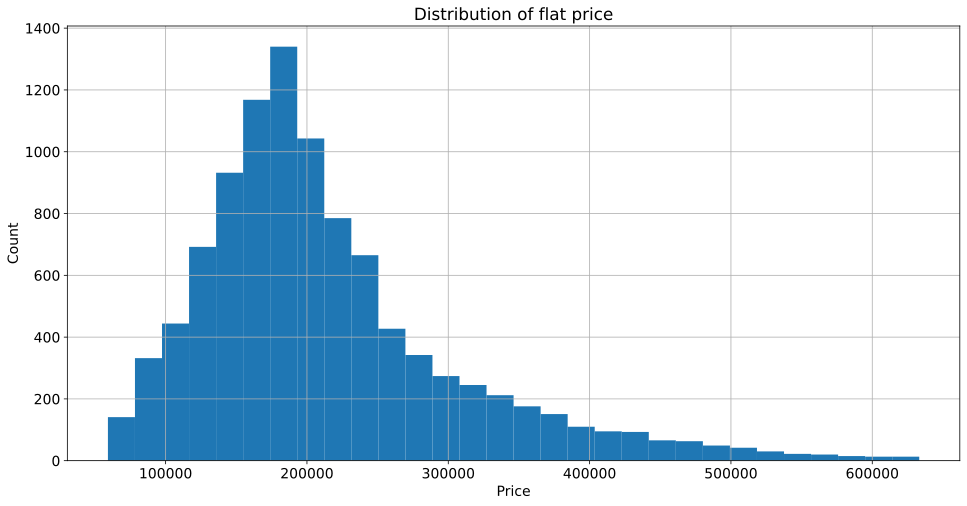

In [17]:
# Распределение целевой переменной
plt.figure(figsize = (16, 8))

train['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Distribution of flat price')
plt.show()

In [18]:
# посчитаем меры центральной тенденции для целевой переменной
target_mean = round(train['Price'].mean(), 2)
target_median = train['Price'].median()
target_mode = train['Price'].mode()[0]

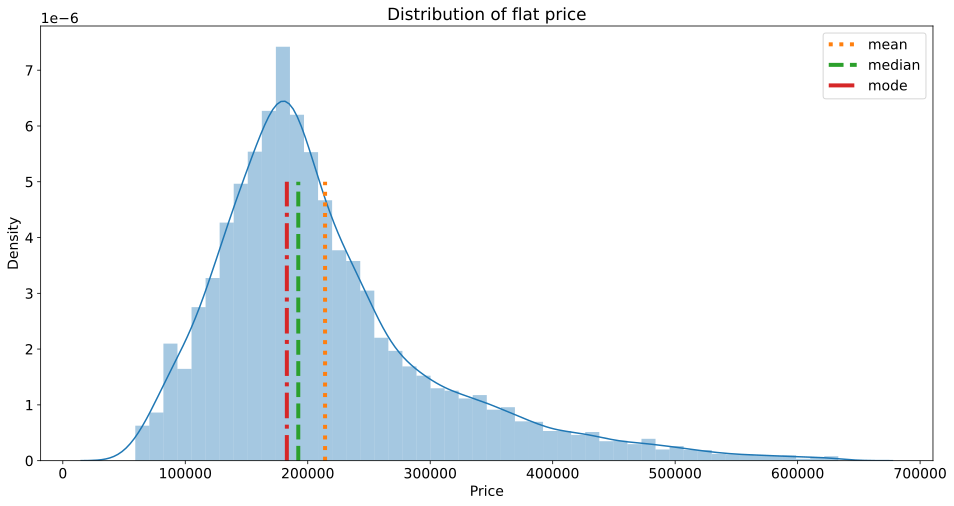

In [19]:
plt.figure(figsize = (16, 8))

sns.distplot(train['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of flat price')
plt.legend()
plt.show()

In [20]:
# ассиметрия
print("Ассиметрия: %f" % train['Price'].skew())

Ассиметрия: 1.366877


###### Распределение целевой переменной нормальное, выбросы отсутствуют. Меры центральной тенденции расположены рядом.

### Анализ признаков

In [21]:
train.describe().transpose()

count           mean            std           min  \
Rooms          10000.0       1.890500       0.839512      0.000000   
Square         10000.0      56.315720      21.058716      1.136859   
LifeSquare      7887.0      37.199665      86.241219      0.370619   
KitchenSquare  10000.0       6.273300      28.560839      0.000000   
Floor          10000.0       8.526700       5.241148      1.000000   
HouseFloor     10000.0      12.609400       6.775974      0.000000   
HouseYear      10000.0    3990.166300  200500.261427   1910.000000   
Ecology_1      10000.0       0.118858       0.119025      0.000000   
Social_1       10000.0      24.687000      17.532614      0.000000   
Social_2       10000.0    5352.157400    4006.799803    168.000000   
Social_3       10000.0       8.039200      23.831875      0.000000   
Healthcare_1    5202.0    1142.904419    1021.519470      0.000000   
Helthcare_2    10000.0       1.319500       1.493601      0.000000   
Shops_1        10000.0       4.231300       4.806341      0.000000   
Price          10000.0  214138.937500   92872.273438  59174.777344   

                         25%            50%            75%           max  
Rooms               1.000000       2.000000       2.000000  1.900000e+01  
Square             41.774879      52.513309      65.900627  6.410652e+02  
LifeSquare         22.769833      32.781261      45.128803  7.480592e+03  
KitchenSquare       1.000000       6.000000       9.000000  2.014000e+03  
Floor               4.000000       7.000000      12.000000  4.200000e+01  
HouseFloor          9.000000      13.000000      17.000000  1.170000e+02  
HouseYear        1974.000000    1977.000000    2001.000000  2.005201e+07  
Ecology_1           0.017647       0.075424       0.195781  5.218670e-01  
Social_1            6.000000      25.000000      36.000000  7.400000e+01  
Social_2         1564.000000    5285.000000    7227.000000  1.908300e+04  
Social_3            0.000000       2.000000       5.000000  1.410000e+02  
Healthcare_1      350.000000     900.000000    1548.000000  4.849000e+03  
Helthcare_2         0.000000       1.000000       2.000000  6.000000e+00  
Shops_1             1.000000       3.000000       6.000000  2.300000e+01  
Price          153872.628906  192269.648438  249135.460938  6.332334e+05

In [22]:
train.select_dtypes(include=['object', 'category']).columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [23]:
train['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
209      1
117      1
199      1
205      1
174      1
Name: DistrictId, Length: 205, dtype: int64

In [24]:
train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [25]:
train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [26]:
train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [27]:
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm')

### 2. Обработка выбросов  <a class='anchor' id='outlier'>

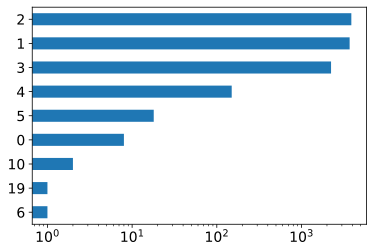

In [28]:
train['Rooms'].value_counts().sort_values().plot(kind='barh', logx=True)
plt.show()

In [29]:
train.loc[train['Rooms'] == 0, 'Rooms'] = 1
train.loc[train['Rooms'] > 6, 'Rooms'] = train['Rooms'].median()

In [30]:
train['Rooms'].value_counts()

2    3883
1    3713
3    2235
4     150
5      18
6       1
Name: Rooms, dtype: int64

In [31]:
train.sort_values(by='Square')

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
7470  14786          1      1    1.136859    4.525736            1.0      3   
4496  15744         34      1    1.988943    2.642219            1.0     21   
9869   3224         27      1    2.377248    0.873147            0.0      1   
8572  10202          6      1    2.596351    4.604943            1.0      3   
161    6782         45      1    2.954309    5.257278            1.0      3   
...     ...        ...    ...         ...         ...            ...    ...   
7644   7917         27      1  212.932358  211.231125            0.0      2   
1906   5548         86      5  275.645294  233.949310           26.0     12   
7010   2307        102      1  409.425171  410.639740           10.0      4   
726      28          9      2  604.705994         NaN            1.0     17   
9229  11602         30      2  641.065186  638.163208           10.0     20   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
7470           1       1977   0.007122         B         B         1   
4496           4       1977   0.069753         B         B        53   
9869           0       1977   0.017647         B         B         2   
8572          25       2014   0.243205         B         B         5   
161            1       1977   0.195781         B         B        23   
...          ...        ...        ...       ...       ...       ...   
7644           3       2008   0.211401         B         B         9   
1906          37       2011   0.161976         B         A        31   
7010           4       2016   0.238617         B         B        26   
726           18       1977   0.161532         B         B        25   
9229          19       2019   0.000078         B         B        22   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
7470       264         0           NaN            0        1       B   
4496     13670         4           NaN            1       11       B   
9869       469         0           NaN            0        0       B   
8572      1564         0         540.0            0        0       B   
161       5212         6           NaN            3        2       B   
...        ...       ...           ...          ...      ...     ...   
7644      1892         0           NaN            0        1       B   
1906      7010         5        4508.0            3        7       B   
7010      3889         6         705.0            3        6       B   
726       5648         1          30.0            2        4       B   
9229      6398       141        1046.0            3       23       B   

              Price  
7470  181434.828125  
4496  458378.781250  
9869  126596.945312  
8572  137597.593750  
161   438005.187500  
...             ...  
7644  302211.250000  
1906  455264.875000  
7010   90470.429688  
726   187717.250000  
9229  133529.687500  

[10000 rows x 20 columns]

In [32]:
(train['LifeSquare'] > train['Square']).sum()

482

In [33]:
train.loc[train['LifeSquare'] > train['Square'], 'LifeSquare'] = train['Square']

In [34]:
(train['LifeSquare'] > train['Square']).sum()

0

In [35]:
train['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
43.0         2
112.0        2
41.0         2
32.0         2
58.0         2
25.0         2
37.0         2
30.0         2
51.0         2
40.0         1
96.0         1
48.0         1
72.0         1
73.0         1
2014.0       1
66.0         1
36.0         1
78.0         1
54.0         1
29.0         1
31.0         1
35.0         1
62.0         1
39.0         1
1970.0       1
60.0         1
75.0         1
26.0         1
21.0         1
84.0         1
63.0         1
123.0        1
53.0         1
42.0         1
23.0         1
27.0         1
Name: KitchenSquare, dtype: int64

In [36]:
train.loc[train['KitchenSquare'] < 3, 'KitchenSquare'] = 3
train.loc[train['KitchenSquare'] > 300, 'KitchenSquare'] = train['KitchenSquare'].median()

In [37]:
from pylab import rcParams
rcParams["figure.figsize"] = 10, 20

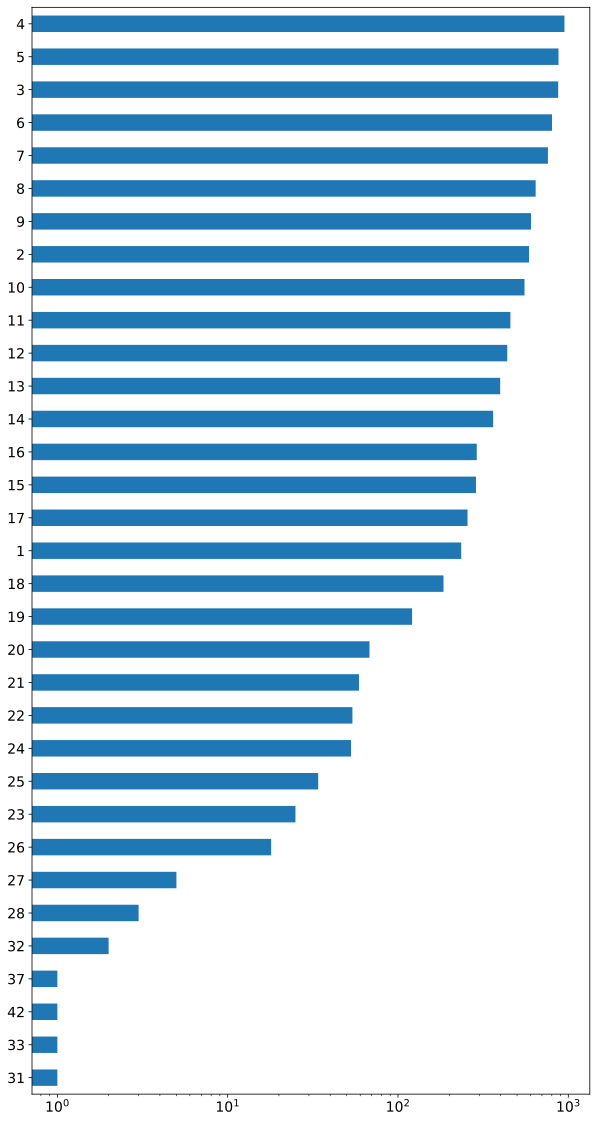

In [38]:
train['Floor'].value_counts().sort_values().plot(kind='barh', logx=True)
plt.show()

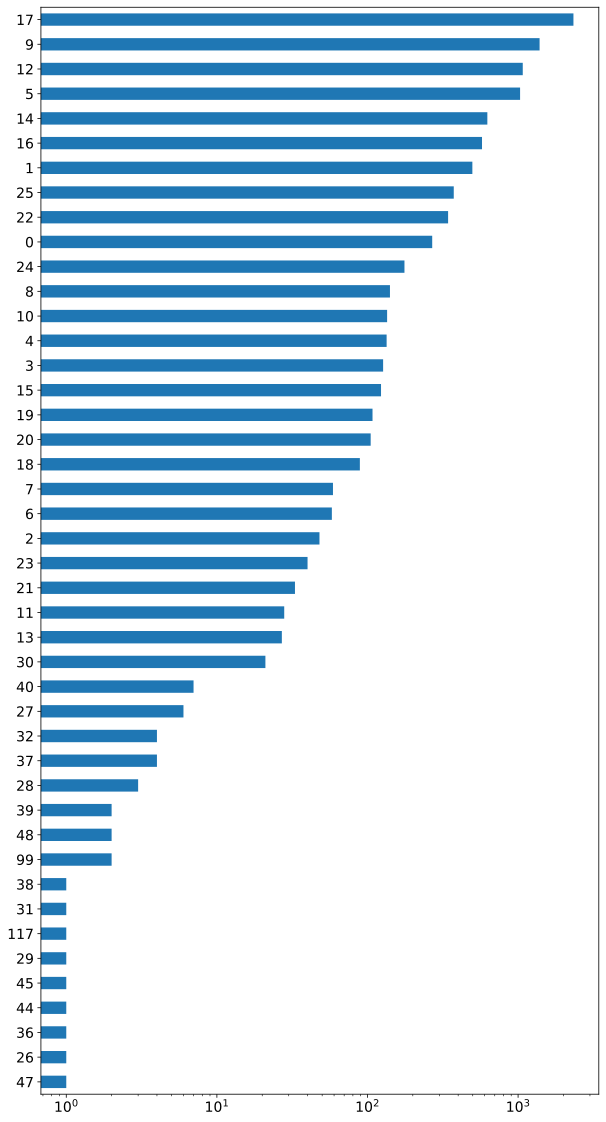

In [39]:
train['HouseFloor'].value_counts().sort_values().plot(kind='barh', logx=True)
plt.show()

In [40]:
(train['Floor'] > train['HouseFloor']).sum()

1825

In [41]:
train.loc[train['Floor'] > train['HouseFloor'], 'Floor'] = train['HouseFloor']

In [42]:
(train['Floor'] > train['HouseFloor']).sum()

0

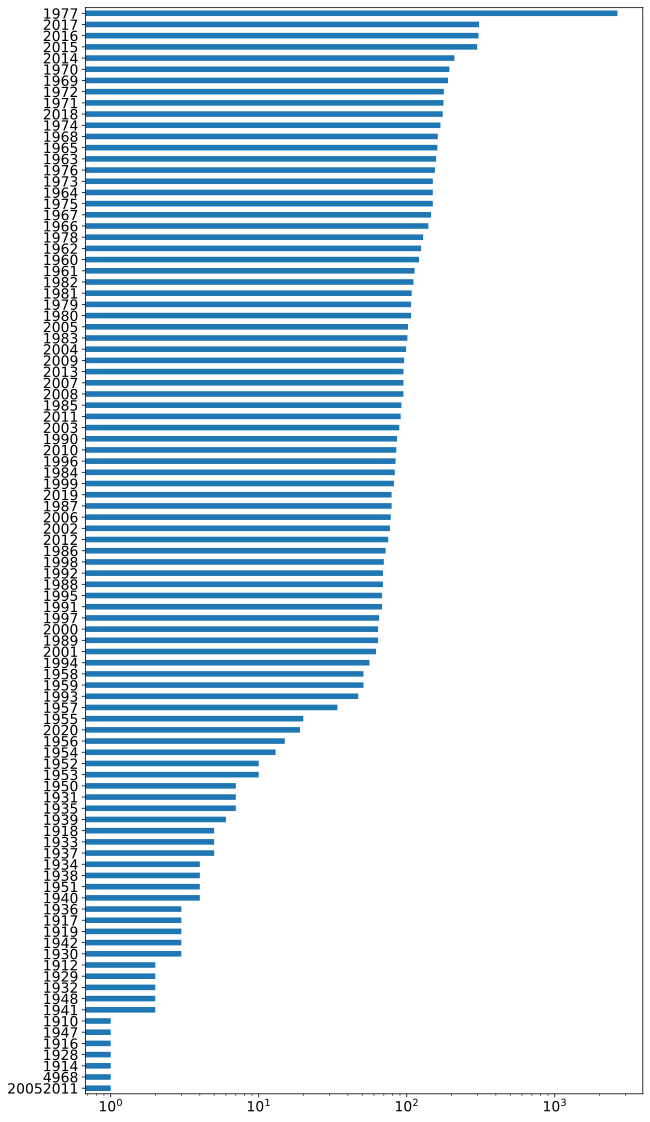

In [43]:
train['HouseYear'].value_counts().sort_values().plot(kind='barh', logx=True)
plt.show()

In [44]:
current_year = datetime.now().year
train.loc[train['HouseYear'] > current_year, 'HouseYear'] = current_year

### 3. Обработка пропусков  <a class='anchor' id='nan'>

In [45]:
train.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [46]:
data_isna = (train.isnull().sum() / len(train)) * 100
data_isna = data_isna.drop(
    data_isna[data_isna == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio, %': data_isna})
missing_data

Missing Ratio, %
Healthcare_1             47.98
LifeSquare               21.13

In [47]:
train.drop('Healthcare_1', axis=1, inplace=True)

In [48]:
median = train['LifeSquare'].median()
train['LifeSquare'].fillna(median, inplace=True)

In [49]:
train.loc[train['LifeSquare'] > train['Square'], 'LifeSquare'] = train['Square']

In [50]:
(train['LifeSquare'] > train['Square']).sum()

0

<AxesSubplot:>

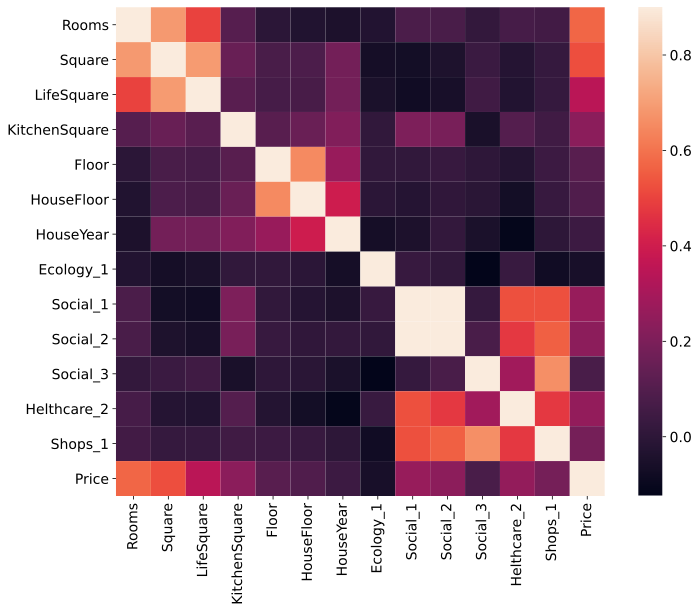

In [51]:
corrmat = train.loc[:, train.columns != 'Id'].corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.9, square=True)

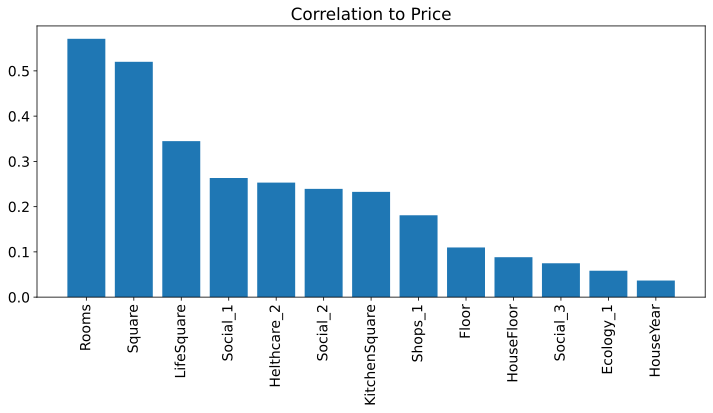

In [52]:
rcParams["figure.figsize"] = 12, 5
corrmat = train.loc[:, train.columns != 'Id'].corrwith(
    train['Price']).abs().sort_values(ascending=False)[1:]
plt.bar(corrmat.index, corrmat.values)
plt.title('Correlation to Price')
plt.xticks(rotation='vertical')
plt.show()

In [53]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[train['Rooms'] > 6, 'Rooms'] = X['Rooms'].median()
        
        # LifeSquare
        X.loc[X['LifeSquare'] > X['Square'], 'LifeSquare'] = X['Square']
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        X.loc[X['KitchenSquare'] > 300, 'KitchenSquare'] = X['KitchenSquare'].median()
        
        # HouseFloor, Floor
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X['HouseFloor']
        
        # HouseYear
        current_year = datetime.now().year
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        median = X['LifeSquare'].median()
        X['LifeSquare'].fillna(median, inplace=True)
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

### 4. Построение новых признаков  <a class='anchor' id='feature'>

In [54]:
binary_to_numbers = {'A': 0, 'B': 1}

train['Ecology_2'] = train['Ecology_2'].replace(binary_to_numbers)
train['Ecology_3'] = train['Ecology_3'].replace(binary_to_numbers)
train['Shops_2'] = train['Shops_2'].replace(binary_to_numbers)

In [55]:
## Доля жилой площади от общей площади квартиры
train['LifeSquare_share'] = train['LifeSquare'] / train['Square'] * 100

In [56]:
train.head()

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809         27      3  115.027313   32.760109           10.0      4   
1   3013         22      1   39.832523   23.169222            8.0      7   
2   8215          1      3   78.342216   47.671970           10.0      2   
3   2352          1      1   40.409908   32.760109            3.0     10   
4  13866         94      2   64.285065   38.562515            9.0     16   

   HouseFloor  HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  \
0          10       2014   0.075424          1          1        11      3097   
1           8       1966   0.118537          1          1        30      6207   
2          17       1988   0.025609          1          1        33      5261   
3          22       1977   0.007122          1          1         1       264   
4          16       1972   0.282798          1          1        33      8667   

   Social_3  Helthcare_2  Shops_1  Shops_2          Price  LifeSquare_share  
0         0            0        0        1  305018.875000         28.480288  
1         1            1        0        1  177734.546875         58.166592  
2         0            3        1        1  282078.718750         60.850937  
3         0            0        1        1  168106.000000         81.069496  
4         2            0        6        1  343995.093750         59.986740

In [57]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.binary_to_numbers = None
        self.Price_per_square_meter = None
        self.LifeSquare_share = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
                
        # Target encoding
        df = X.copy()
        
        # square   
        if y is not None:
            df['Price'] = y.values
            df['Price_per_square_meter'] = df['Price'] / df['Square']
            df['LifeSquare_share'] = df['LifeSquare'] / df['Square'] * 100
         
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # LifeSquare_share
        X['LifeSquare_share'] = X['LifeSquare'] / X['Square'] * 100
        
        return X            

### 5. Отбор признаков  <a class='anchor' id='feature_selection'>

In [58]:
train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'LifeSquare_share']

In [59]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['LifeSquare_share']

target_name = 'Price'

### 6. Разбиение на train и test  <a class='anchor' id='split'>

In [60]:
train = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)

In [61]:
X = train.drop(columns=target_name)
y = train[target_name]

In [62]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [63]:
y_train.reset_index(drop=True, inplace=True)
y_valid.reset_index(drop=True, inplace=True)

In [64]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test = preprocessor.transform(test)

X_train.shape, X_valid.shape, test.shape

((6700, 18), (3300, 18), (5000, 18))

In [65]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test = features_gen.transform(test)

X_train.shape, X_valid.shape, test.shape

((6700, 19), (3300, 19), (5000, 19))

In [66]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test = test[feature_names + new_feature_names]

In [67]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test.isna().sum().sum()

(0, 0, 0)

### 7. Построение модели  <a class='anchor' id='modeling'>

#### Обучение

In [68]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=21)

#### Оценка модели

Train R2:	0.961
Test R2:	0.718


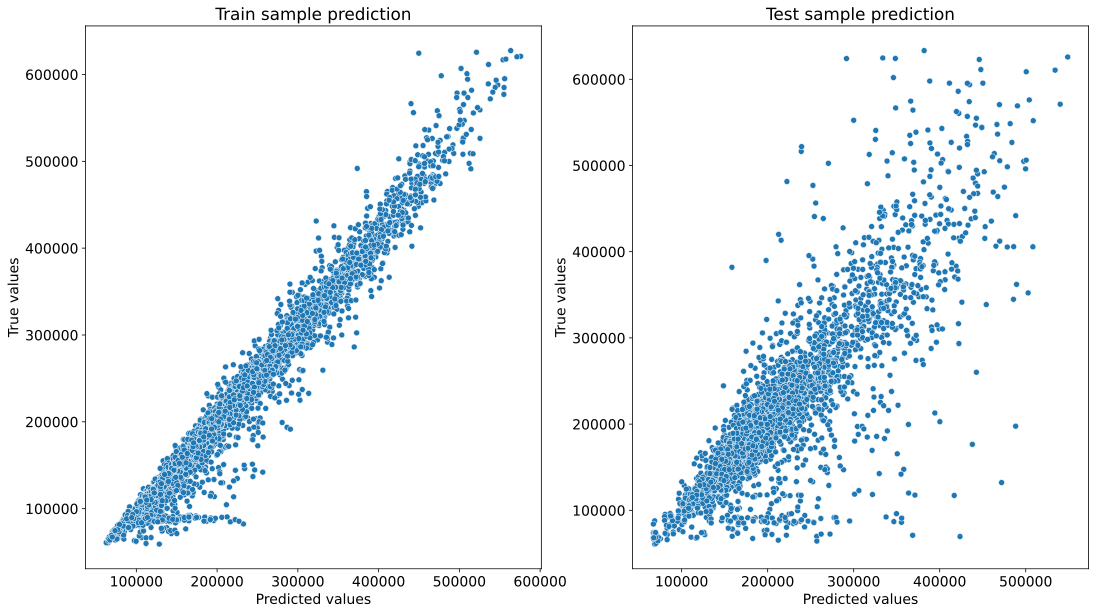

In [69]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#### Кросс-валидация

In [70]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.6868271 , 0.70254697, 0.72021619])

In [71]:
cv_score.mean()

0.7031967537910883

#### Важность признаков

In [72]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

feature_name  importance
1             Square    0.388057
10          Social_1    0.118415
11          Social_2    0.091252
0              Rooms    0.068975
12          Social_3    0.065287
7          Ecology_1    0.050110
6          HouseYear    0.045398
3      KitchenSquare    0.030348
16  LifeSquare_share    0.028927
2         LifeSquare    0.026220
5         HouseFloor    0.025836
4              Floor    0.023777
14           Shops_1    0.023561
13       Helthcare_2    0.011630
15           Shops_2    0.001107
9          Ecology_3    0.000724
8          Ecology_2    0.000378

#### RandomForestRegressor

Train R2:	0.855
Test R2:	0.721


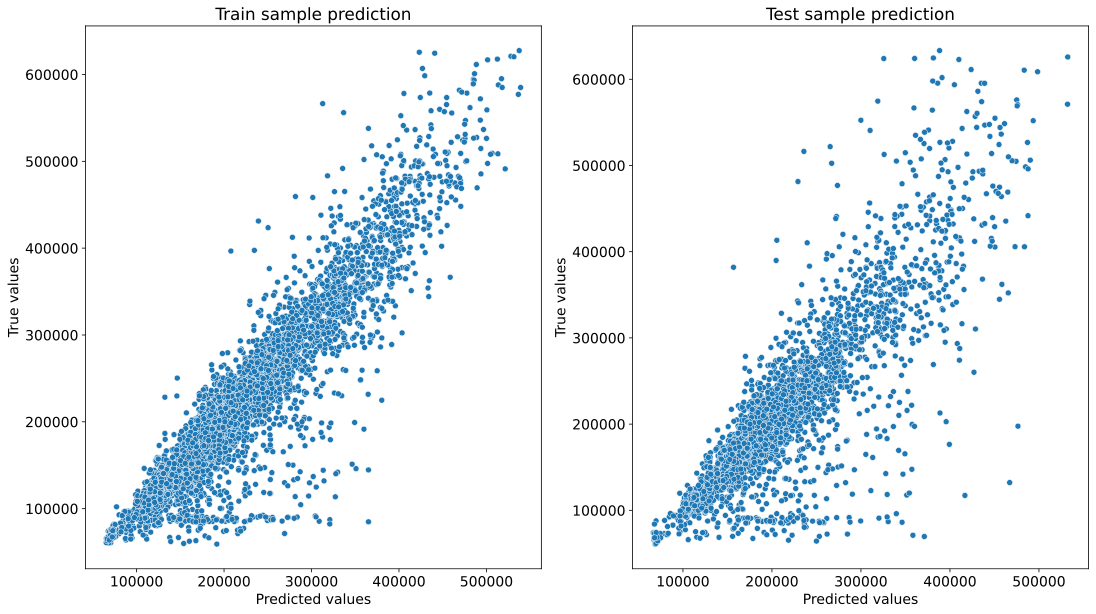

In [73]:
RFR = RandomForestRegressor(n_estimators=1000, max_depth=12, min_samples_leaf=4,  random_state=42)
RFR.fit(X_train, y_train)
y_test_preds = RFR.predict(X_valid)
y_train_preds = RFR.predict(X_train)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#### GradientBoostingRegressor

Train R2:	0.897
Test R2:	0.74


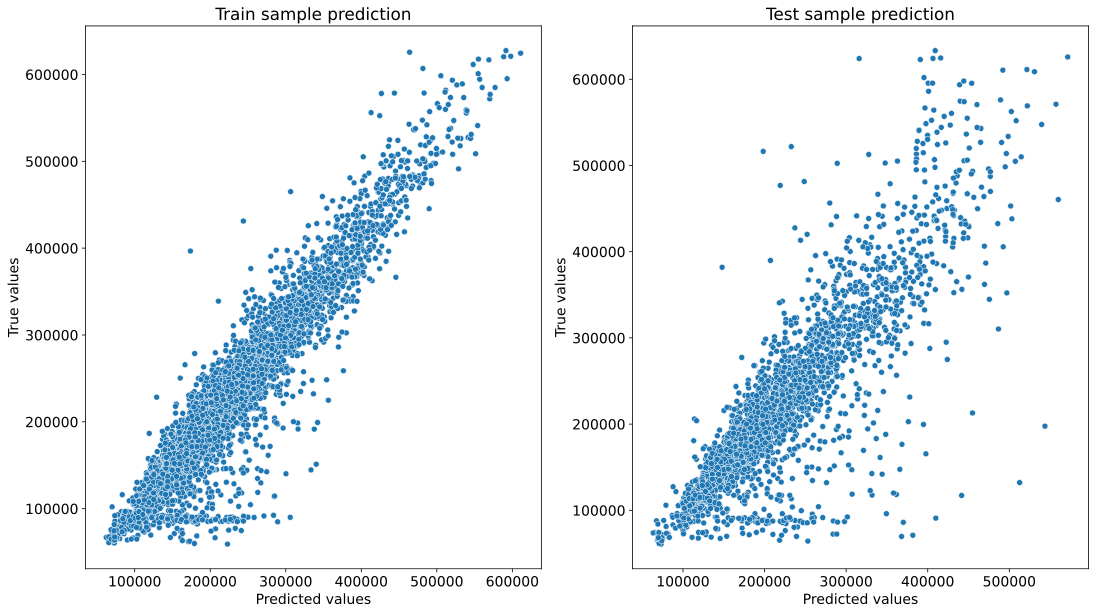

In [74]:
GBR = GradientBoostingRegressor(random_state=42,
                               criterion='mse',
                               n_estimators=200,
                               max_depth=5,
                               min_samples_leaf=4)

GBR.fit(X_train, y_train)
y_test_preds = GBR.predict(X_valid)
y_train_preds = GBR.predict(X_train)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [75]:
train = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)

In [76]:
X = train.drop(columns=target_name)
y = train[target_name]

In [77]:
preprocessor = DataPreprocessing()
preprocessor.fit(X)

X = preprocessor.transform(X)
test = preprocessor.transform(test)

features_gen = FeatureGenetator()
features_gen.fit(X, y)

X = features_gen.transform(X)
test = features_gen.transform(test)

X = X[feature_names + new_feature_names]
test = test[feature_names + new_feature_names]

X.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

In [78]:
GBR.fit(X, y)
y_preds = GBR.predict(X)
evaluate_preds(y, y_preds, y, y_preds)

Train R2:	0.87
Test R2:	0.87


### 8. Прогнозирование на тестовом датасете  <a class='anchor' id='prediction'>

In [79]:
SUBMISSION_PATH = './sample_submission.csv'
submit = pd.read_csv(SUBMISSION_PATH)

In [83]:
predictions = GBR.predict(test)
predictions

array([161486.17620474, 128303.97882572, 139022.31987435, ...,
       149451.48216091, 192369.11424218, 277315.05853284])

In [84]:
submit['Price'] = predictions
submit.head()

Id          Price
0  4567  161486.176205
1  5925  128303.978826
2   960  139022.319874
3  3848  115458.656866
4   746  190023.270659

In [85]:
submit.to_csv('final_submit.csv', index=False)